<a href="https://colab.research.google.com/github/KaterinaVat/PINNs/blob/main/pinns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam

DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [2]:
class Net(torch.nn.Module):
  def __init__(self, indim = 1, outdim =1):
    super().__init__()
    self.actf = torch.tanh
    self.lin1 = torch.nn.Linear(indim, 100)
    self.lin2 = torch.nn.Linear(100, outdim)

  def forward(self, x):
    x = self.lin1(x)
    x = self.lin2(self.actf(x))
    return x.squeeze()

In [3]:
class MyData(Dataset):
  def __init__(self, in_tensor, out_tensor):
    self.inp = in_tensor
    self.out = out_tensor

  def __len__(self):
    return len(self.inp)

  def __getitem__(self, idx):
    return self.inp[idx], self.out[idx]

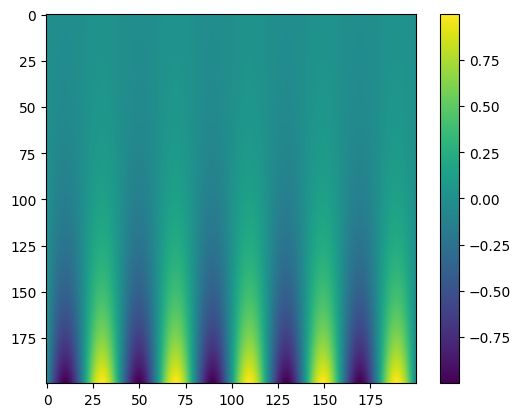

In [4]:
#generating dataset
def u(x,t):
  return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 200
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)

X,T = np.meshgrid(xs, ts)
U = u(X,T)
plt.imshow(U)
plt.colorbar()

In [5]:
train_in = torch.tensor([[x, t] for x, t in zip(X.flatten(), T.flatten())], dtype=torch.float32, requires_grad=True)
train_out = torch.tensor(u(X.flatten(), T.flatten()), dtype = torch.float32)
# u - действительное значение функции
# a = np.array([[1, 2],[3, 4]])
#  array([1, 2, 3, 4])
# перенос обучения на устройство
train_in.to(DEVICE)
train_out.to(DEVICE)

train_dataset = MyData(train_in, train_out)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = True)

In [6]:
model = Net(indim =2, outdim = 1).to(DEVICE)
epochs = 1000
optimizer = Adam(model.parameters(), lr = 0.1)
# список всех параметров нейросети (весов и смещений), которые нужно обучать.
loss_fcn = torch.nn.MSELoss()

for epoch in range(epochs):
  for batch_in, batch_out in train_dataloader:
    batch_in.requires_grad_()
    batch_in.to(DEVICE)
    batch_out.to(DEVICE)
    model.train() #включение режима обучения

    def closure():
      optimizer.zero_grad()
      loss = loss_fcn(model(batch_in), batch_out)
      loss.backward()
      return loss
    optimizer.step(closure)
  model.eval() #режим оценки
  epoch_loss = loss_fcn(model(train_in),train_out) #здесь я уже считаю финальный
  #лосс на всем датасете без батчей
  print(f'Epoch: {epoch+1} | Loss: {round(float(epoch_loss), 4)}')



Epoch: 1 | Loss: 0.0649
Epoch: 2 | Loss: 0.0619
Epoch: 3 | Loss: 0.0631
Epoch: 4 | Loss: 0.1338
Epoch: 5 | Loss: 0.0926
Epoch: 6 | Loss: 0.0741
Epoch: 7 | Loss: 0.1026
Epoch: 8 | Loss: 0.0693
Epoch: 9 | Loss: 0.0814
Epoch: 10 | Loss: 0.0688
Epoch: 11 | Loss: 0.0643
Epoch: 12 | Loss: 0.0702
Epoch: 13 | Loss: 0.0611
Epoch: 14 | Loss: 0.0774
Epoch: 15 | Loss: 0.057
Epoch: 16 | Loss: 0.0532
Epoch: 17 | Loss: 0.0586
Epoch: 18 | Loss: 0.0357
Epoch: 19 | Loss: 0.0398
Epoch: 20 | Loss: 0.0308
Epoch: 21 | Loss: 0.0188
Epoch: 22 | Loss: 0.0213
Epoch: 23 | Loss: 0.0149
Epoch: 24 | Loss: 0.0193
Epoch: 25 | Loss: 0.033
Epoch: 26 | Loss: 0.019
Epoch: 27 | Loss: 0.0166
Epoch: 28 | Loss: 0.0205
Epoch: 29 | Loss: 0.0094
Epoch: 30 | Loss: 0.0085
Epoch: 31 | Loss: 0.0127
Epoch: 32 | Loss: 0.0115
Epoch: 33 | Loss: 0.0112
Epoch: 34 | Loss: 0.0105
Epoch: 35 | Loss: 0.0085
Epoch: 36 | Loss: 0.0144
Epoch: 37 | Loss: 0.0116
Epoch: 38 | Loss: 0.0169
Epoch: 39 | Loss: 0.0097
Epoch: 40 | Loss: 0.0083
Epoch: 41 | 

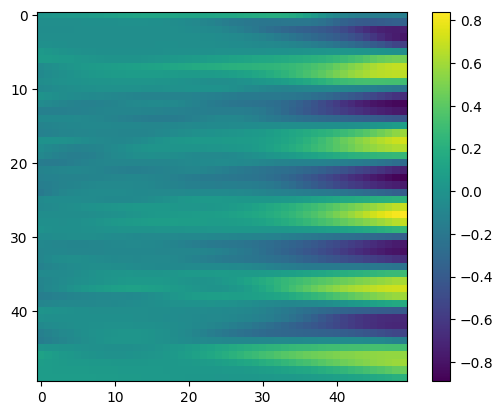

In [8]:
def u_model(xs, ts):
  pts = torch.tensor(np.array([[x,t] for x,t in zip(xs, ts)]), dtype = torch.float32)
  return model(pts)

pts = 50
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)
X, T = np.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x,t in zip(X,T):
  img.append(u_model(x,t).detach().numpy().tolist())
  # детач дает возможность просто сохранить результат а не обучать модель

plt.imshow(img)
plt.colorbar()

In [9]:
from torch.autograd import grad

def phys_loss(inp, out):
  # inp - переменная по которой берется производные - то есть x и t (нужно чтобы брать градиенты по входам)
  # out - предсказание модели. то, по чему берется прозводные du/dx, du^2/dx^2, du/dt
    dudt = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,1]
    dudx = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,0]
    d2udx2 = grad(dudx, inp, grad_outputs=torch.ones_like(dudx), create_graph=True, allow_unused=True)[0][:,0]
    return torch.nn.MSELoss()(d2udx2, 0.5*dudt)

Furthermore, you need to add more training data at t=0 to evaluate loss at the boundary and make the model meet our boundary condition prescribed by Eq (1).

In [11]:
bdry_pts = 200
xs_bdry = np.linspace(-5, 5, bdry_pts)
ts_bdry = np.asarray([0 for x in xs_bdry])
us_bdry = u(xs_bdry, ts_bdry)
train_in_bd = torch.tensor([[x,t] for x, t in zip(xs_bdry, ts_bdry)],  dtype=torch.float32, requires_grad=True)
train_out_bd = torch.tensor(us_bdry, dtype = torch.float32)

train_in_bd.to(DEVICE)
train_out_bd.to(DEVICE)

tensor([-6.1232e-16, -1.5721e-01, -3.1052e-01, -4.5610e-01, -5.9034e-01,
        -7.0989e-01, -8.1179e-01, -8.9350e-01, -9.5299e-01, -9.8877e-01,
        -9.9997e-01, -9.8629e-01, -9.4809e-01, -8.8630e-01, -8.0247e-01,
        -6.9869e-01, -5.7752e-01, -4.4199e-01, -2.9547e-01, -1.4160e-01,
         1.5786e-02,  1.7278e-01,  3.2549e-01,  4.7009e-01,  6.0301e-01,
         7.2092e-01,  8.2091e-01,  9.0048e-01,  9.5765e-01,  9.9101e-01,
         9.9972e-01,  9.8357e-01,  9.4295e-01,  8.7888e-01,  7.9295e-01,
         6.8730e-01,  5.6456e-01,  4.2778e-01,  2.8036e-01,  1.2596e-01,
        -3.1569e-02, -1.8831e-01, -3.4037e-01, -4.8397e-01, -6.1552e-01,
        -7.3177e-01, -8.2982e-01, -9.0723e-01, -9.6208e-01, -9.9300e-01,
        -9.9922e-01, -9.8059e-01, -9.3758e-01, -8.7124e-01, -7.8324e-01,
        -6.7575e-01, -5.5146e-01, -4.1346e-01, -2.6517e-01, -1.1028e-01,
         4.7343e-02,  2.0379e-01,  3.5517e-01,  4.9772e-01,  6.2789e-01,
         7.4244e-01,  8.3853e-01,  9.1376e-01,  9.6

In [15]:
from torch.autograd import Variable

In [20]:
model_pinn = Net(indim=2, outdim=1).to(DEVICE)
epochs = 1000
optimizer_pinn = Adam(model_pinn.parameters(), lr=0.1)
loss_fcn = torch.nn.MSELoss()

for epoch in range(epochs):
  for batch_in, batch_out in train_dataloader:
    batch_in = Variable(batch_in, requires_grad=True)
    batch_in.to(DEVICE)
    batch_out.to(DEVICE)
    model_pinn.train()
    def closure():
      optimizer_pinn.zero_grad()
      loss = loss_fcn(model_pinn(batch_in), batch_out) #loss нейросетки
      loss +=phys_loss(batch_in, model_pinn(batch_in))  #loss физический
      loss += loss_fcn(model_pinn(train_in_bd), train_out_bd)
      loss.backward()
      return loss
    optimizer_pinn.step(closure)
  model_pinn.eval()
  base_loss = loss_fcn(model_pinn(train_in), train_out)
  phy_loss = phys_loss(train_in, model_pinn(train_in))
  bdry_loss = loss_fcn(model_pinn(train_in_bd),train_out_bd)
  epoch_loss = base_loss + phy_loss + bdry_loss
  print(f'Epoch: {epoch+1} | Loss: {round(float(epoch_loss), 4)} = {round(float(base_loss), 4)} + {round(float(phy_loss), 4)} + {round(float(bdry_loss), 4)}')

Epoch: 1 | Loss: 0.5417 = 0.0633 + 0.0024 + 0.4759
Epoch: 2 | Loss: 0.5341 = 0.0634 + 0.0023 + 0.4684
Epoch: 3 | Loss: 0.5329 = 0.0672 + 0.006 + 0.4597
Epoch: 4 | Loss: 0.527 = 0.0621 + 0.0074 + 0.4575
Epoch: 5 | Loss: 0.5711 = 0.0765 + 0.0111 + 0.4836
Epoch: 6 | Loss: 0.5416 = 0.0854 + 0.0149 + 0.4413
Epoch: 7 | Loss: 0.5485 = 0.0911 + 0.0131 + 0.4444
Epoch: 8 | Loss: 0.5145 = 0.0681 + 0.0176 + 0.4289
Epoch: 9 | Loss: 0.5179 = 0.059 + 0.0246 + 0.4343
Epoch: 10 | Loss: 0.505 = 0.0572 + 0.0277 + 0.4201
Epoch: 11 | Loss: 0.4958 = 0.059 + 0.0308 + 0.4061
Epoch: 12 | Loss: 0.5001 = 0.0684 + 0.0546 + 0.3771
Epoch: 13 | Loss: 0.5269 = 0.0832 + 0.0777 + 0.3661
Epoch: 14 | Loss: 0.4521 = 0.0501 + 0.0526 + 0.3494
Epoch: 15 | Loss: 0.4677 = 0.0592 + 0.064 + 0.3445
Epoch: 16 | Loss: 0.4841 = 0.0552 + 0.0872 + 0.3417
Epoch: 17 | Loss: 0.4379 = 0.0563 + 0.0703 + 0.3113
Epoch: 18 | Loss: 0.4427 = 0.054 + 0.0982 + 0.2904
Epoch: 19 | Loss: 0.4873 = 0.0444 + 0.127 + 0.316
Epoch: 20 | Loss: 0.4425 = 0.0

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


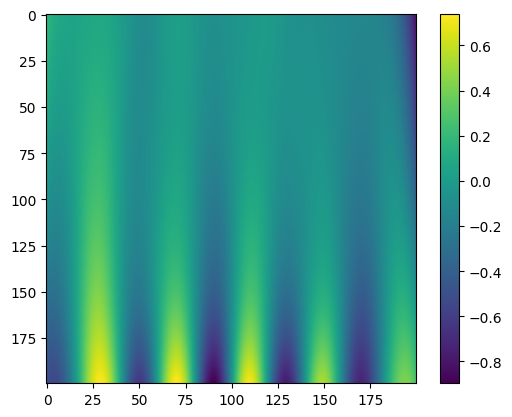

In [21]:
def u_model_pinn(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model_pinn(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)

X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_pinn(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()